# Sat problem solver

DIMACS is a file format used to describe satisfiability problems [see reference](http://www.satcompetition.org/2009/format-benchmarks2009.html)

In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle
from qiskit.providers import aer
import numpy as np

In [2]:
# Parse the dimacs file
fileName = '3sat.dimacs'
with open(fileName, 'r') as f:
  dimacs = f.read()
print(dimacs)

c example DIMACS-CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0


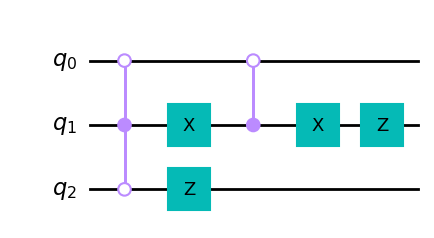

In [3]:
# use PhaseOracle to create an oracle circuit https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/circuit/library/phase_oracle.py#L103
oracle = PhaseOracle.from_dimacs_file(fileName)
oracle.draw(output='mpl')

In [4]:
class Verifier():
    """Create an object that can be used to check whether
    an assignment satisfies a DIMACS file.
        Args:
            dimacs_file (str): path to the DIMACS file
    """
    def __init__(self, dimacs_file):
        with open(dimacs_file, 'r') as f:
            self.dimacs = f.read()

    def is_correct(self, guess):
        """Verifies a SAT solution against this object's
        DIMACS file.
            Args:
                guess (str): Assignment to be verified.
                             Must be string of 1s and 0s.
            Returns:
                bool: True if `guess` satisfies the
                           problem. False otherwise.
        """
        # Convert characters to bools & reverse
        guess = [bool(int(x)) for x in guess][::-1]
        for line in self.dimacs.split('\n'):
            line = line.strip(' 0')
            clause_eval = False
            for literal in line.split(' '):
                if literal in ['p', 'c']:
                    # line is not a clause
                    clause_eval = True
                    break
                if '-' in literal:
                    literal = literal.strip('-')
                    lit_eval = not guess[int(literal)-1]
                else:
                    lit_eval = guess[int(literal)-1]
                clause_eval |= lit_eval
            if clause_eval is False:
                return False
        return True

In [5]:
test_solution = '101'
verifier = Verifier(fileName)
verifier.is_correct(test_solution)

True

In [6]:
# Configure backend
backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)

# Create a new problem from the phase oracle and the
# verification function
problem = AmplificationProblem(oracle=oracle, is_good_state=verifier.is_correct)

# Use Grover's algorithm to solve the problem
grover = Grover(quantum_instance=quantum_instance)
result = grover.amplify(problem)
print(result.top_measurement)
verifier.is_correct(result.top_measurement)

000


True

In [7]:
import json
with open('result.json', 'w') as f:
  json_string = json.dumps(result.circuit_results)
  f.write(json_string)

with open('solutions.txt', 'w') as f:
  for list in result.circuit_results:
    for state, counts in list.items():
      # if counts < 50:
      f.write('%s: %s\n' % (state, counts))
      f.write(str(verifier.is_correct(state)) + '\n')

Running on an IBMQ computer

In [8]:
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
IBMQ.ibmq.enable_account()
IBMQ.ibmq.load_account()
provider = IBMQ.ibmq.get_provider('ibm-q')

AttributeError: 'NoneType' object has no attribute 'enable_account'